In [1]:
abstract type BoundaryCondition
end

type Dirichlet <: BoundaryCondition
    ū₀::Float64
    ūₗ::Float64
end

type Neumann <: BoundaryCondition
    ∂ū₀::Float64
    ∂ūₗ::Float64
end

type Periodic <: BoundaryCondition
end

type Discretization
    Nₓ::Int64
    Δx::Float64
    Nₜ::Int64
    Δt::Float64
end

type SpaceTime
    L::Float64 #spacial extent
    tf::Float64 #time span of simulation
end

#Determine the number of spatial unknowns at each time step.
function nb_spatial_unknowns(discretization::Discretization, bc::BoundaryCondition)
    if typeof(bc) == Neumann
        return discretization.Nₓ
    elseif typeof(bc) == Dirichlet
        return discretization.Nₓ - 2
    elseif typeof(bc) == Periodic
        return discretization.Nₓ - 1
    end
end

function build_tri_diagonal_matrix(discretization::Discretization, λ::Float64, bc::BoundaryCondition)
    # determine number of unknowns based on boundary condition
    matrix_dim = nb_spatial_unknowns(discretization, bc)

    A = zeros(matrix_dim, matrix_dim)

    for i = 1:matrix_dim
        A[i, i] = 1 + 2 * λ
    end

    for i = 1:matrix_dim - 1
        A[i, i+1] = -λ
        A[i+1, i] = -λ
    end

    if typeof(bc) == Periodic
        A[1, end] = -λ 
        A[end, 1] = -λ  
    elseif typeof(bc) == Neumann
        A[1, 2] = -2 * λ
        A[end, end - 1] = -2 * λ
    end

    return A

end

build_tri_diagonal_matrix (generic function with 1 method)

In [2]:
using Calculus
using ProgressMeter
"""
Arguments:
* f: reaction term f(x, t, u)
* u₀: initial condition u₀(x)
* bc::BoundaryCondition: boundary condition
* D::Float64: diffusion coefficient
* Nₓ::Int: number of spatial discretization points
* st::SpaceTime: space-time over which solution to PDE is approximated
* sample_time::Float64: stores u every sample_time time steps
"""
function solve_rxn_diffn_eqn(f, u₀, bc::BoundaryCondition, D::Float64, Nₓ::Int, st::SpaceTime, sample_time::Float64)

    # compute Δx, Nₜ, Δt below.
    discretization = Discretization(Nₓ, NaN, 0, NaN)

    # ensure that the boundary condition is consistent with the initial condition
    if isa(bc, Dirichlet)
        @assert(bc.ū₀ ≈ u₀(0.0),
            "The initial condition is inconsistent with Dirichlet boundary condition.")
        @assert(isapprox(bc.ūₗ, u₀(st.L), atol = 1e-10),
            "The initial condition is inconsistent with Dirichlet boundary condition.")
    elseif isa(bc, Periodic)
        @assert(u₀(0.0) ≈ u₀(st.L),
            "The initial condition is inconsistent with Periodic boundary conditions.")
    elseif isa(bc, Neumann)
        @assert(isapprox(bc.∂ū₀, derivative(u₀, 0.0), atol = 1e-10),
            "The initial condition is inconsistent with Neumann boundary condition.")
        @assert(isapprox(bc.∂ūₗ, derivative(u₀, st.L), atol = 1e-10),
            "The initial condition is inconsistent with Neumann boundary condition.")
    end

    # discretize space.
    x = collect(linspace(0, st.L, discretization.Nₓ)) # includes end points!
    discretization.Δx = x[2] - x[1]
    @printf("%d points in x-discretization. dx = %f\n", discretization.Nₓ, discretization.Δx)

    # discreteize time.
    discretization.Δt = discretization.Δx ^ 2
    discretization.Nₜ = ceil(Int, st.tf / discretization.Δt)
    @printf("%d points in t-discretization. dt = %f\n", discretization.Nₜ, discretization.Δt)

    # nondimensional parameter involved in discreteization
    λ = (D * discretization.Δt) / (2 * (discretization.Δx) ^ 2)

    # build tri-diagonal matrix
    A = build_tri_diagonal_matrix(discretization, λ, bc)

    nb_unknowns = nb_spatial_unknowns(discretization, bc)

    # initialize u at k = 0
    # this u is the value of u(x, t) when t = k - 1 over discretized x points.
    u = u₀.(x)

    # trim u and x so that i index corresponds to xᵢ and uᵢ,ₖ
    if typeof(bc) == Neumann
        # all are unknown, no trimming required
    elseif typeof(bc) == Dirichlet
        u = u[2:end-1]
        x = x[2:end-1]
    elseif typeof(bc) == Periodic
        u = u[1:end-1]
        x = x[1:end-1]
    end
    @assert(length(u) == nb_unknowns)
    @assert(length(x) == nb_unknowns)

    # initialize right-hand side of matrix eqn. solved at each time step.
    rhs = zeros(Float64, nb_unknowns)

    # initialize u_sample and t_sample to be filled below with specific time steps for graphing purposes
    num_samples = ceil(Int, st.tf / sample_time) # determines size of u_sample and t_sample
    sample_freq = floor(Int, discretization.Nₜ / (num_samples - 1)) # don't count the 0 sample
    u_sample = zeros(Float64, discretization.Nₓ, num_samples) # nb_unknowns = size of u, num_samples, how many u's we will store
    t_sample = zeros(Float64, num_samples)
    sample_counter = 1 # for if loop below to identify column of u_sample, increments below after u_sample is imput

    # take time steps.
    @showprogress 1 "Computing..." for k = 1:discretization.Nₜ
       # time here, inside the loop
        t = discretization.Δt * k

        # Store u and t every sample_time so we can plot.
        if (k == 1) || (k % sample_freq == 0)
            # Different bc's have different num of unknowns, so we account for that here
            # Dirichlet and Periodic bc's are added later
            if typeof(bc) == Neumann
                 u_sample[:, sample_counter] = u
            elseif typeof(bc) == Dirichlet
                u_sample[2:end-1, sample_counter] = u
            elseif typeof(bc) == Periodic
                u_sample[1:end-1, sample_counter] = u
            end
                t_sample[sample_counter] = t - discretization.Δt
                sample_counter += 1
         end

        # build right-hand side vector of matrix eqn.
        for i = 1:nb_unknowns
            # contribution from first order discretization of time derivative
            rhs[i] = u[i]
            # contribution from reaction term
            rhs[i] += f(x[i], t, u[i]) * discretization.Δt
            # TODO contribution from advection?
            # contribution from spatial Laplacian
            if (i != 1) && (i != nb_unknowns)
                rhs[i] += λ * (u[i - 1] - 2 * u[i] + u[i + 1])
            end
         end

         # based on boundary condition, handle first and last component of Laplacian.
         if typeof(bc) == Neumann
         # -4 and 4 come from making "ghost points" as described by Gustafson (u₀ and uₙ₊₁ are considered our ghost points)
         # ∂ū₀ = (u₂ - u₀)/(2 * Δx) which means u₀ = -2 * Δx * ∂ū₀ + u₂
         # substitute u₀ in the right hand side of the diffusion equation at i = 1 to get the equation below for rhs[1]
         # by the same logic, use uₙ₊₁ = 2 * Δx * ∂ūₗ + uₙ₋₁ for the right hand side of the diffusion equation at i = end
             rhs[1] += λ * (-4.0 * discretization.Δx * bc.∂ū₀ + 2 * u[2] - 2 * u[1])
             rhs[end] += λ * (4.0 * discretization.Δx * bc.∂ūₗ + 2 * u[end - 1] - 2 * u[end])
         elseif typeof(bc) == Dirichlet
             # Simply input the known boundary condition for Dirichlet
             rhs[1] += λ * (bc.ū₀ - 2 * u[1] + u[2])
             rhs[end] += λ  * (u[end - 1] - 2 * u[end]  + bc.ūₗ)
         elseif typeof(bc) == Periodic
             # draw a circle to see.
             # u[-1] is actually u[end] by PBCs
             rhs[1] += λ * (u[end] - 2 * u[1] + u[2])
             # u[end+1] is actually u[1]
             rhs[end] += λ * (u[end - 1] - 2 * u[end] + u[1])
         end

         # solve for u at next time step (overwrite previous)
         u = A \ rhs
    end

    # add in boundary conditions to Dirichlet and Periodic
    if typeof(bc) == Dirichlet
        # insert bc's for first and last rows
        u_sample[1, :] = bc.ū₀
        u_sample[end, :] = bc.ūₗ
        # add first and last spatial step to x
        x = vcat([0.0], x, [st.L])
    elseif typeof(bc) == Periodic
        # assign last row to be the same as first since Periodic bc's
        u_sample[end, :] = u_sample[1, :]
        # add last spatial step to x
        push!(x, st.L)
    end

    return t_sample, x, u_sample

end

solve_rxn_diffn_eqn

In [8]:
#Periodic BC Test
function exact_u(x::Float64, t::Float64, D::Float64)
    return exp(-(2 * π)^2 * D * t) * (4 * sin(2 * π * x) + 6 * cos(2 * π * x)) + x * (x - 1)
end

D = 0.01

f(x::Float64, t::Float64, u::Float64) = -2 * D
u₀(x::Float64) = 4 * sin(2 * π * x) + 6 * cos(2 * π * x) + x * (x - 1)

bc = Periodic()

Nₓ = 1000
st = SpaceTime(1.0, 0.1)
sample_time = 0.01 

t, x, u = solve_rxn_diffn_eqn(f, u₀, bc, D, Nₓ, st, sample_time)

1000 points in x-discretization. dx = 0.001001
99801 points in t-discretization. dt = 0.000001


Computing...100%|███████████████████████████████████████| Time: 0:58:48


([0.0, 0.0111102, 0.0222214, 0.0333326, 0.0444438, 0.0555551, 0.0666663, 0.0777775, 0.0888887, 0.0999999], [0.0, 0.001001, 0.002002, 0.003003, 0.004004, 0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901  …  0.990991, 0.991992, 0.992993, 0.993994, 0.994995, 0.995996, 0.996997, 0.997998, 0.998999, 1.0], [6.0 5.96185 … 5.75946 5.73206; 6.02404 5.98676 … 5.78363 5.75613; … ; 5.97372 5.93666 … 5.73505 5.70776; 6.0 5.96185 … 5.75946 5.73206])

In [5]:
x

100-element Array{Float64,1}:
 0.0      
 0.010101 
 0.020202 
 0.030303 
 0.040404 
 0.0505051
 0.0606061
 0.0707071
 0.0808081
 0.0909091
 0.10101  
 0.111111 
 0.121212 
 ⋮        
 0.888889 
 0.89899  
 0.909091 
 0.919192 
 0.929293 
 0.939394 
 0.949495 
 0.959596 
 0.969697 
 0.979798 
 0.989899 
 1.0      

In [6]:
t

10-element Array{Float64,1}:
 0.0     
 0.111009
 0.22212 
 0.333231
 0.444342
 0.555454
 0.666565
 0.777676
 0.888787
 0.999898

In [7]:
import PyPlot; const plt = PyPlot
function draw_heat_map(t, x, u)
    Nₜ = length(t)
    Nₓ = length(x)

    X = similar(transpose(u))
    T = similar(transpose(u))

    for i = 1:Nₜ
        X[i,:] = x
    end

    for i = 1:Nₓ
        T[:,i] = t
    end

    plt.figure()
    plt.pcolormesh(X,T, transpose(u))
    plt.xlabel("x")
    plt.ylabel("t")
    plt.colorbar(label="Concentration of u")
    plt.savefig("heatmap.png")
    if typeof(bc) == Neumann
        plt.title("Neumann Boundary Conditions")
    elseif typeof(bc) == Dirichlet
        plt.title("Dirichlet Boundary Conditions")
    elseif typeof(bc) == Periodic
        plt.title("Periodic Boundary Conditions")
    end

end

draw_heat_map (generic function with 1 method)

In [9]:
function create_exact_u(t, x, exact_u, D)
    Nₜ = length(t)
    Nₓ = length(x)
    u_e = zeros(Float64, Nₓ, Nₜ)
    for i = 1:Nₓ
        for j = 1:Nₜ
            u_e[i,j] = exact_u(x[i], t[j], D)
        end
    end
    return u_e
end

u_e = create_exact_u(t, x, exact_u, D)

1000×10 Array{Float64,2}:
 6.0      5.97374  5.94759  5.92156  …  5.84415  5.81857  5.7931   5.76774
 6.02404  5.99767  5.97141  5.94527     5.86754  5.84185  5.81628  5.79081
 6.04784  6.02136  5.995    5.96875     5.89069  5.8649   5.83922  5.81366
 6.07141  6.04482  6.01835  5.992       5.91362  5.88773  5.86194  5.83627
 6.09473  6.06804  6.04147  6.01501     5.93632  5.91032  5.88443  5.85866
 6.11782  6.09103  6.06434  6.03778  …  5.95878  5.93268  5.90669  5.88081
 6.14067  6.11377  6.08698  6.06031     5.98101  5.9548   5.92871  5.90274
 6.16328  6.13627  6.10938  6.08261     6.003    5.9767   5.95051  5.92443
 6.18564  6.15853  6.13154  6.10467     6.02476  5.99836  5.97207  5.94589
 6.20776  6.18055  6.15346  6.12649     6.04628  6.01978  5.99339  5.96712
 6.22964  6.20233  6.17514  6.14807  …  6.06756  6.04096  6.01448  5.98811
 6.25127  6.22387  6.19658  6.16941     6.08861  6.06191  6.03533  6.00887
 6.27266  6.24516  6.21777  6.1905      6.10942  6.08262  6.05595  6.02939

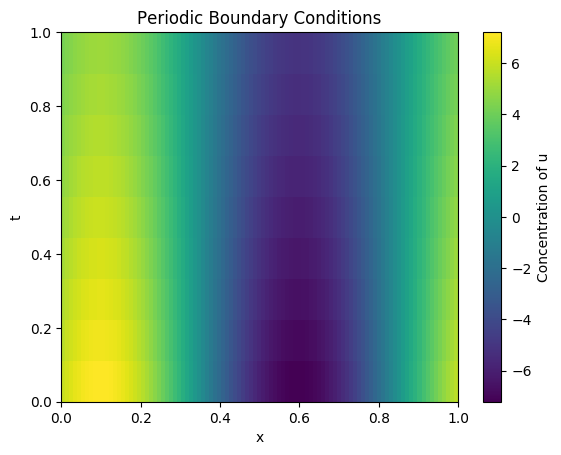

PyObject <matplotlib.text.Text object at 0x0000000004386E80>

In [18]:
draw_heat_map(t, x, u)

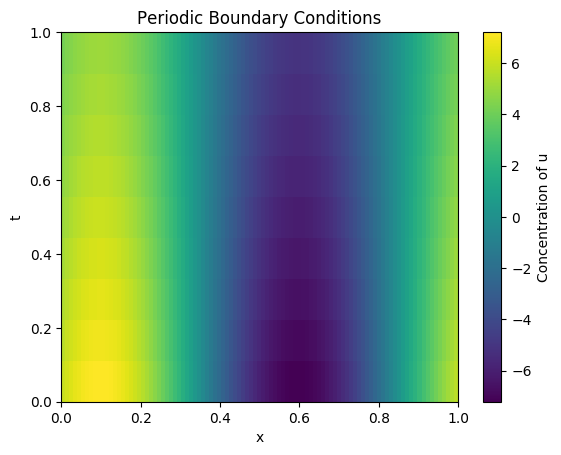

PyObject <matplotlib.text.Text object at 0x0000000004445668>

In [19]:
draw_heat_map(t, x, u_e)

In [10]:
u

1000×10 Array{Float64,2}:
 6.0      5.96185  5.93078  5.90097  …  5.81502  5.7871   5.75946  5.73206
 6.02404  5.98676  5.95558  5.92566     5.83939  5.81137  5.78363  5.75613
 6.04784  6.01137  5.98011  5.9501      5.86352  5.8354   5.80755  5.77994
 6.07141  6.0357   6.00437  5.97426     5.8874   5.85917  5.83122  5.80351
 6.09473  6.05973  6.02835  5.99817     5.91101  5.88269  5.85464  5.82684
 6.11782  6.08348  6.05206  6.0218   …  5.93438  5.90596  5.87782  5.84992
 6.14067  6.10693  6.0755   6.04517     5.95749  5.92898  5.90074  5.87274
 6.16328  6.1301   6.09865  6.06827     5.98034  5.95174  5.92341  5.89532
 6.18564  6.15298  6.12154  6.0911      6.00294  5.97425  5.94583  5.91765
 6.20776  6.17557  6.14414  6.11366     6.02528  5.9965   5.968    5.93973
 6.22964  6.19787  6.16647  6.13595  …  6.04736  6.0185   5.98991  5.96155
 6.25127  6.21988  6.18853  6.15798     6.06918  6.04024  6.01156  5.98312
 6.27266  6.24161  6.21031  6.17973     6.09073  6.06172  6.03297  6.00444

In [11]:
u_e

1000×10 Array{Float64,2}:
 6.0      5.97374  5.94759  5.92156  …  5.84415  5.81857  5.7931   5.76774
 6.02404  5.99767  5.97141  5.94527     5.86754  5.84185  5.81628  5.79081
 6.04784  6.02136  5.995    5.96875     5.89069  5.8649   5.83922  5.81366
 6.07141  6.04482  6.01835  5.992       5.91362  5.88773  5.86194  5.83627
 6.09473  6.06804  6.04147  6.01501     5.93632  5.91032  5.88443  5.85866
 6.11782  6.09103  6.06434  6.03778  …  5.95878  5.93268  5.90669  5.88081
 6.14067  6.11377  6.08698  6.06031     5.98101  5.9548   5.92871  5.90274
 6.16328  6.13627  6.10938  6.08261     6.003    5.9767   5.95051  5.92443
 6.18564  6.15853  6.13154  6.10467     6.02476  5.99836  5.97207  5.94589
 6.20776  6.18055  6.15346  6.12649     6.04628  6.01978  5.99339  5.96712
 6.22964  6.20233  6.17514  6.14807  …  6.06756  6.04096  6.01448  5.98811
 6.25127  6.22387  6.19658  6.16941     6.08861  6.06191  6.03533  6.00887
 6.27266  6.24516  6.21777  6.1905      6.10942  6.08262  6.05595  6.02939

In [12]:
@assert(isapprox(u, u_e, rtol=.001), "Matrices are not equivalent.")